In [1]:
#%%
"""         Chem 210A/B --  C.W. McCurdy -- January 2021
   
 Read a file with potential curve values and find bound states 
              for particle with specified mass

 Finite Element Method - Discrete Variable Representation (FEM-DVR) 
 for 1D Schroedinger equation using Gauss-Lobatto quadrature in each finite element
 Uses class DVRHelper() to construct FEM-DVR points, weights and Kinetic Energy

 Shows how to 
   (1) Read in and interpolate a potential function known at discrete points
       using cubic spline interpretation
   (2) Use DVRHelper class to build FEM-DVR grid
   (3) Use DVRHelper class to build Hamiltonian in DVR basis
   (4) Find eigenvalues and eigenvectors of Hamiltonian
   (5) Plot eigenfunctions of the Hamiltonian

 Example: Harmonic Oscillator with potential specified at 25 points in x
          on the interval -5 bohr to + 5 bohr.   Solved using a mass of an 
          H atom using a DVR on -2 to 2 bohr.

 Student Exercise: 
          H2 vibrational states using CI singles and doubles potential curve
          from Psi4 provided at 500 input points.
          This potential yields a n = 0 -> 1 excitation energy 
          within a few wavenumbers of the value using the NIST values for
          constants of diatomic molecules for H2 in the formula
           E_n = (n+1/2)we - (n+1/2)^2 wexe, which is 4158 cm^-1

"""
#%%
# preliminaries to invoke SciPy linear algebra functions 
from scipy import linalg as LA
# and NumPy which is used to define pi, sqrt, array, .transpose etc. as np
import numpy as np
from scipy.interpolate import CubicSpline  
import matplotlib.pyplot as plt  # import matplotlib pyplot functions
from matplotlib import animation  # for animation from same class library
import os  # functions to manipulate files and directories
from DVR.DVRHelper import DVRHelper  # contains Barbalinardo/McCurdy FEM-DVR and Crank Nicolson functions
import time as timeclock  # for timing parts of the calculation during debugging
from datascience import*
%matplotlib inline 
plt.style.use('fast')
#
#============== Make Directory for Plots if it's not there already ==========
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Plot_Output = path+'/Plot_Output'
if os.path.exists(Plot_Output):
    print("Directory for wave function plots already exists",Plot_Output)
else:
    print("Attempting to create directory for wave function plots ",Plot_Output)
    try:  
        os.mkdir(Plot_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Plot_Output)
    else:  
        print ("Successfully created the directory %s " % Plot_Output)
#
#=== Make Directory for for the .dat output  if it's not there already ======
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Data_Output = path+'/Data_Output'
if os.path.exists(Data_Output):
    print("Directory for output .dat files  already exists",Plot_Output)
else:
    print("Attempting to create directory for .dat output files  ",Plot_Output)
    try:  
        os.mkdir(Data_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Data_Output)
    else:  
        print ("Successfully created the directory %s " % Data_Output)
# ===================================================================
wfcn_plotfile=open("Data_Output/wavefunctions.dat","w") # data file for saving wavefunctions
#
#=============Constants and conversion factors ==============
Daltons_to_eMass = 1822.89
bohr_to_Angstrom = 0.529177
Hartree_to_eV = 27.211386245988 # NIST ref
eV_to_wavennumber = 8065.54393734921 # NIST ref on constants + conversions 
Hartree_to_wavenumber = 2.1947463136320e5    # value from NIST ref on constants + conversions
atu_to_fs = 24.18884326509/1000
HartreeToKelvin = 315773;

The current working directory is C:\Users\Delilahs PC\Downloads
Directory for wave function plots already exists C:\Users\Delilahs PC\Downloads/Plot_Output
The current working directory is C:\Users\Delilahs PC\Downloads
Directory for output .dat files  already exists C:\Users\Delilahs PC\Downloads/Plot_Output


In [2]:
#=====================================FEM_DVR===================================
#  Set up the FEM DVR grid given only the Finite Element boundaries and order
#  of Gauss Lobatto quadrature,  and compute the Kinetic Energy matrix for 
#  this FEM DVR for Mass = mass set in call (atomic units).
#
# Here is where the reduced mass (or mass for any 1D problem) is set 
#He_Mass = 4.0026 
#O_Mass =  15.99491461957 # O 16 mass from NIST tables
#He_Mass =  4.002603254
He_Mass = 2.001301627#H atom atomic mass
#H_Mass = 1
epsilonKelvin =  11.061
epsilon = epsilonKelvin/315773
rm = 5.602
mu = He_Mass*Daltons_to_eMass # Convert mass to atomic units (mass of the electron)
n_order = 30  # order of the DVR in each finite element is set here
               # routines work for quadrature orders up to at least 150
#FEM_boundaries = [0.2,5,10,20,30]
FEM_boundaries = np.linspace(3,300,100)

In [3]:
(4.002603254*4.002603254)/(4.002603254+4.002603254)

2.001301627

In [4]:
dvr = DVRHelper(n_order, FEM_boundaries,Mass=mu)
print("\nFEM-DVR basis of ", dvr.nbas, " functions")
#print(dvr.nbas)
#   Function to define potential at x and t (if potential is time-dependent)
#   DVRHelper class library expects function for V(x,t) in general


From FEM_DVR_build: building grid and KE with Gauss Lobatto quadrature of order  30
element  1  xmin =  3.0  xmax =  6.0
element  2  xmin =  6.0  xmax =  9.0
element  3  xmin =  9.0  xmax =  12.0
element  4  xmin =  12.0  xmax =  15.0
element  5  xmin =  15.0  xmax =  18.0
element  6  xmin =  18.0  xmax =  21.0
element  7  xmin =  21.0  xmax =  24.0
element  8  xmin =  24.0  xmax =  27.0
element  9  xmin =  27.0  xmax =  30.0
element  10  xmin =  30.0  xmax =  33.0
element  11  xmin =  33.0  xmax =  36.0
element  12  xmin =  36.0  xmax =  39.0
element  13  xmin =  39.0  xmax =  42.0
element  14  xmin =  42.0  xmax =  45.0
element  15  xmin =  45.0  xmax =  48.0
element  16  xmin =  48.0  xmax =  51.0
element  17  xmin =  51.0  xmax =  54.0
element  18  xmin =  54.0  xmax =  57.0
element  19  xmin =  57.0  xmax =  60.0
element  20  xmin =  60.0  xmax =  63.0
element  21  xmin =  63.0  xmax =  66.0
element  22  xmin =  66.0  xmax =  69.0
element  23  xmin =  69.0  xmax =  72.0
element  

In [5]:
LJ = []
for i in FEM_boundaries:
    pot = epsilon * ( ((rm/(i))**12) - (2*((rm/(i)))**6)) 
    LJ.append(pot)

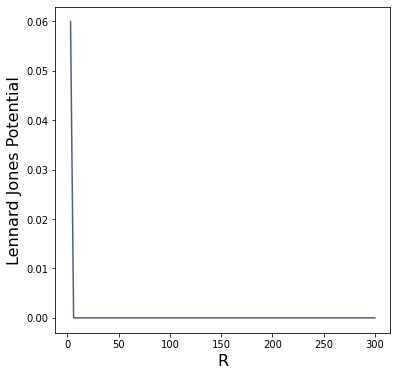

In [6]:
Table().with_columns("R",FEM_boundaries,"Lennard Jones Potential",LJ).plot(0)

In [7]:
LJ2 = []
for i in np.linspace(5,300,300):
    pot = epsilon * ( ((rm/(i))**12) - (2*((rm/(i)))**6)) 
    LJ2.append(pot)

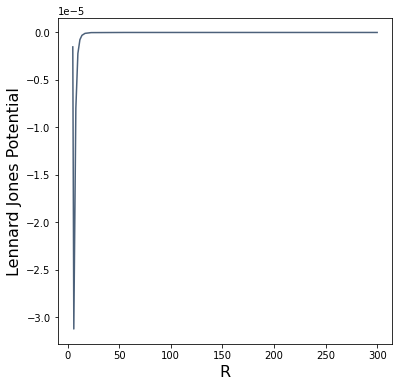

In [8]:
# this shows the well a but better
Table().with_columns("R",np.linspace(5,300,300),"Lennard Jones Potential",LJ2).plot(0)

In [9]:
LJ2

[-1.5204499993237382e-06,
 -3.1245550064441536e-05,
 -1.630095006209864e-05,
 -7.995608580223576e-06,
 -4.095457469884898e-06,
 -2.217953658123468e-06,
 -1.2654916746886936e-06,
 -7.559149631010067e-07,
 -4.6981323536758004e-07,
 -3.022085882347312e-07,
 -2.003006568317882e-07,
 -1.362831181313799e-07,
 -9.48951172422732e-08,
 -6.744700788260023e-08,
 -4.882571051984433e-08,
 -3.593300110544733e-08,
 -2.684139804426392e-08,
 -2.0322924968672022e-08,
 -1.5578228876214657e-08,
 -1.2076681750261731e-08,
 -9.459686798582455e-09,
 -7.480901272684884e-09,
 -5.968526516756886e-09,
 -4.80107233035984e-09,
 -3.8915114876806585e-09,
 -3.1767540022451004e-09,
 -2.6105513726698317e-09,
 -2.1586470673193667e-09,
 -1.7954195265452568e-09,
 -1.501530391747333e-09,
 -1.26225839904324e-09,
 -1.0663065545459275e-09,
 -9.049396608891672e-10,
 -7.713548654299993e-10,
 -6.602182132609513e-10,
 -5.673205744443898e-10,
 -4.893201770180801e-10,
 -4.235485018210388e-10,
 -3.6786290418373075e-10,
 -3.2053395655

In [10]:
# this converges to -4.4930981559110185e-09 hartress or 0.001418K or compared to the paper 1.418mK

In [11]:
def Lennard_Jones (r,time):
    Potential = epsilon * ( ((rm/r)**12) - (2*((rm/r)**6)) )
    return Potential

In [12]:
LJ_Vectorize = np.vectorize(Lennard_Jones)
# =============Build Hamiltonian (using general routine with dummy time t=0)=========
#     Pass name of potential function explicitly here
time = 0.0
H_mat = dvr.Hamiltonian(LJ_Vectorize, time)
print("\n Completed construction of Hamiltonian ")
#====================================================================================
#
# Find all the eigenvalues of the Hamiltonian so we can compare with known bound state energies
# or make a plot of the spectrum -- For a time-independent Hamiltonian example here
#
EigenVals = LA.eigvalsh(H_mat)
#
n_energy = 10 
print("\n            Lowest ", n_energy,"   Eigenvalues of the DVR Hamiltonian \n")
for  i in range(0,n_energy):
     print("E( ",i,") =   ",EigenVals[i]," hartrees, excitation energy = ",(EigenVals[i]-EigenVals[0])* Hartree_to_wavenumber," cm^-1")
#====================================================================================
#
# Extract the n_Plot'th eigenfunction for plotting and use as initial wave function
# to test propagation
#
number_of_eigenvectors = n_energy 
#
#  Here n_Plot picks which eigenfunction to plot
n_Plot = 0  # pick a state of this potential to plot < number_of_eigenvectors -1
#
print("Calculating ",number_of_eigenvectors," eigenvectors for plotting eigenfunctions")
EigenVals, EigenVecs  = LA.eigh(H_mat,eigvals=(0,number_of_eigenvectors))
wfcnPlot = []
for j in range(0,dvr.nbas):
    wfcnPlot.append(EigenVecs[j,n_Plot])
#


 Completed construction of Hamiltonian 

            Lowest  10    Eigenvalues of the DVR Hamiltonian 

E(  0 ) =    -9.764160767423325e-08  hartrees, excitation energy =  0.0  cm^-1
E(  1 ) =    2.0391747907836705e-08  hartrees, excitation energy =  0.025905327204936306  cm^-1
E(  2 ) =    7.871110754945467e-08  hartrees, excitation energy =  0.038704947163618296  cm^-1
E(  3 ) =    1.7128229972924734e-07  hartrees, excitation energy =  0.05902197544213023  cm^-1
E(  4 ) =    2.9644394868217106e-07  hartrees, excitation energy =  0.08649178220688342  cm^-1
E(  5 ) =    4.5356414300374027e-07  hartrees, excitation energy =  0.12097567893532417  cm^-1
E(  6 ) =    6.423756848781584e-07  hartrees, excitation energy =  0.1624150224853295  cm^-1
E(  7 ) =    8.627454896064821e-07  hartrees, excitation energy =  0.21078060414165872  cm^-1
E(  8 ) =    1.11459572548026e-06  hartrees, excitation energy =  0.2660553418187911  cm^-1
E(  9 ) =    1.3978742001920156e-06  hartrees, excitation ene

In [13]:
# normalize  wave function from diagonalization
#
norm_squared = 0.
for j in range(0,dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcnPlot[j])**2    
wfcnPlot = wfcnPlot/np.sqrt(norm_squared)
norm_squared = 0.
for j in range(0,dvr.nbas):
    norm_squared = norm_squared + np.abs(wfcnPlot[j])**2    
print("Norm of wave function being plotted is ", np.sqrt(norm_squared))
#

Norm of wave function being plotted is  0.9999999999999999



 Plot wave function  0  (numbered in order of increasing energy)

 Running from terminal, close figure window to proceed and make .pdf file of figure


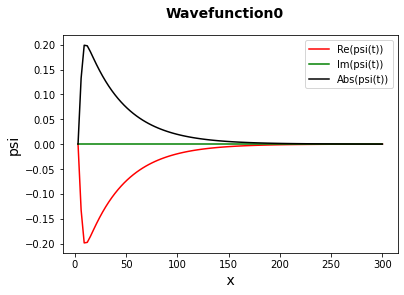

In [14]:
#================# Plot the  wave function specified by n_Plot above======================
#   It must be type np.complex for this general wave function plotting logic
#
Cinitial  = np.zeros((dvr.nbas), dtype=complex) 
wfcnInitialPlot  = np.zeros((dvr.nbas), dtype=complex) 
for j in range(0,dvr.nbas):
   Cinitial[j] = wfcnPlot[j]
#
print("\n Plot wave function ",n_Plot," (numbered in order of increasing energy)")
title = 'Wavefunction'+str(n_Plot)
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Cinitial, plot_title_string=title,N_plot_points=len(FEM_boundaries),make_plot=True)
# write the data in file also
for j in range(0,len(FEM_boundaries)):
    print(FEM_boundaries,"  ",np.real(FEM_boundaries),"  ",np.imag(FEM_boundaries),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
#


 Average value of r using DVR for the integral, <r> =  25.915351365181543

 Running from terminal, close figure window to proceed and make .pdf file of figure


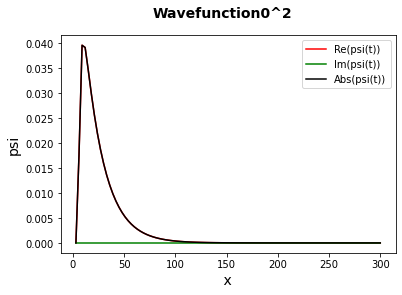

In [15]:
# plot square of wave function (radial probability distribution)
#
Csquared=np.zeros(dvr.nbas,dtype=complex)
raverage = 0.0
for i in range(dvr.nbas):
   Csquared[i] = np.abs(Cinitial[i])**2 / np.sqrt(dvr.w_pts[i+1])
#   compute <r> for this wave function
#   note that Cinitial[i] contains the necessary weight, sqrt(dvr.w_pts[i+1])
   raverage = raverage + np.abs(Cinitial[i])**2 *dvr.x_pts[i+1]
print("\n Average value of r using DVR for the integral, <r> = ",raverage)
title = 'Wavefunction'+str(n_Plot)+"^2"
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Csquared, plot_title_string=title,N_plot_points=len(FEM_boundaries),make_plot=True)
# write the data in file also
for j in range(0,len(FEM_boundaries)):
    print(FEM_boundaries,"  ",np.real(FEM_boundaries),"  ",np.imag(FEM_boundaries),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
#
exit()